# Zona Metropolitana

> Este tutorial muestra el flujo completo para crear y analizar variables de uso de suelo y estructura urbana para una zoma metropolitana completa, en este caso la Zona Metropolitana del Valle de México.

Vamos a integrar los siguientes datos utilizando una malla regular.

* Red de calles
* Usos de suelo extraídos de actividades económicas
* Algunas variables densales

In [ ]:
import geopandas as gpd
import pandas as pd
from pyLandUseMX.descargas import *
from pyLandUseMX.usodesuelo import *
from pyLandUseMX.denue import *
import contextily as cx
import os


## Malla 

Lo primero que vamos a hacer es crear la malla en la que estaremos integrando los datos

El archivo ya está descargado
EPSG:4326


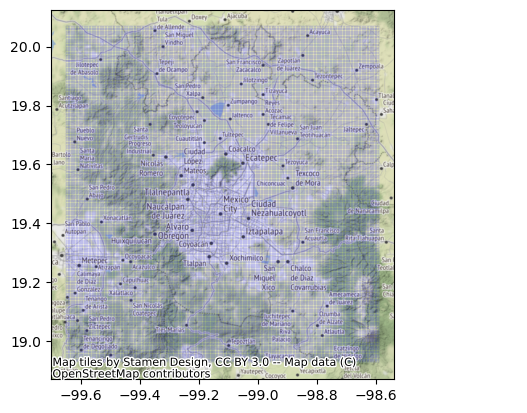

In [ ]:
pth = descarga_raster_ejemplo()
malla = Malla.desde_raster(pth)
ax = malla.datos.boundary.plot(edgecolor="blue", linewidth=0.07)
ax = cx.add_basemap(ax, crs=malla.crs)


## Red

Vamos a agregar en nuestra malla tres tipos diferentes de vialidades:

* Acceso controlado
* Primarias
* Secundarias 
* Residenciales

Cada una de estas corresponde a un conjunto diferente de _tag_id_ en los datos de OSM



In [ ]:
# descargamos y leemos la red
pth_red = os.path.join(DOWNLOADS_PATH, "red_zmvm_completa.gpkg")
red = gpd.read_file(pth_red)
# definimos los tipos de vialidades y filtramos
id_acceso_c = [100, 101, 102, 103, 104, 105]
id_primarias = [106, 107]
id_secundarias = 108
id_terciarias = 109
id_residencial = 110
acceso_controlado = red.loc[red.tag_id.isin(id_acceso_c)]
primarias = red.loc[red.tag_id.isin(id_primarias)]
secundarias = red.loc[red.tag_id == id_secundarias]
terciarias = red.loc[red.tag_id == id_terciarias]
residenciales = red.loc[red.tag_id == id_residencial]

Ya tenemos los datos para cada tipo de vialidad, ahora podemos agregarlos a nuestra malla

In [ ]:
malla = (malla
         .agrega_lineas(acceso_controlado, campo='Acceso controlado')
         .agrega_lineas(primarias, campo='Vialidades primarias')
         .agrega_lineas(secundarias, campo='Vialidades secundarias')
         .agrega_lineas(terciarias, campo='Vialidades terciarias')
         .agrega_lineas(residenciales, campo='Calles residenciales'))
malla.datos

,geometry,grid_id,Acceso controlado,Vialidades primarias,Vialidades secundarias,Vialidades terciarias,Calles residenciales
0,"POLYGON ((-99.65011 20.06836, -99.65011 20.059...",0,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((-99.64113 20.06836, -99.64113 20.059...",1,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((-99.63215 20.06836, -99.63215 20.059...",2,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((-99.62317 20.06836, -99.62317 20.059...",3,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((-99.61418 20.06836, -99.61418 20.059...",4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
14963,"POLYGON ((-98.63502 18.93649, -98.63502 18.927...",14963,0.0,0.0,0.0,0.0,0.0
14964,"POLYGON ((-98.62604 18.93649, -98.62604 18.927...",14964,0.0,0.0,0.0,0.0,0.0
14965,"POLYGON ((-98.61705 18.93649, -98.61705 18.927...",14965,0.0,0.0,0.0,0.0,0.0
14966,"POLYGON ((-98.60807 18.93649, -98.60807 18.927...",14966,0.0,0.0,0.0,0.0,0.0


<xarray.plot.facetgrid.FacetGrid>

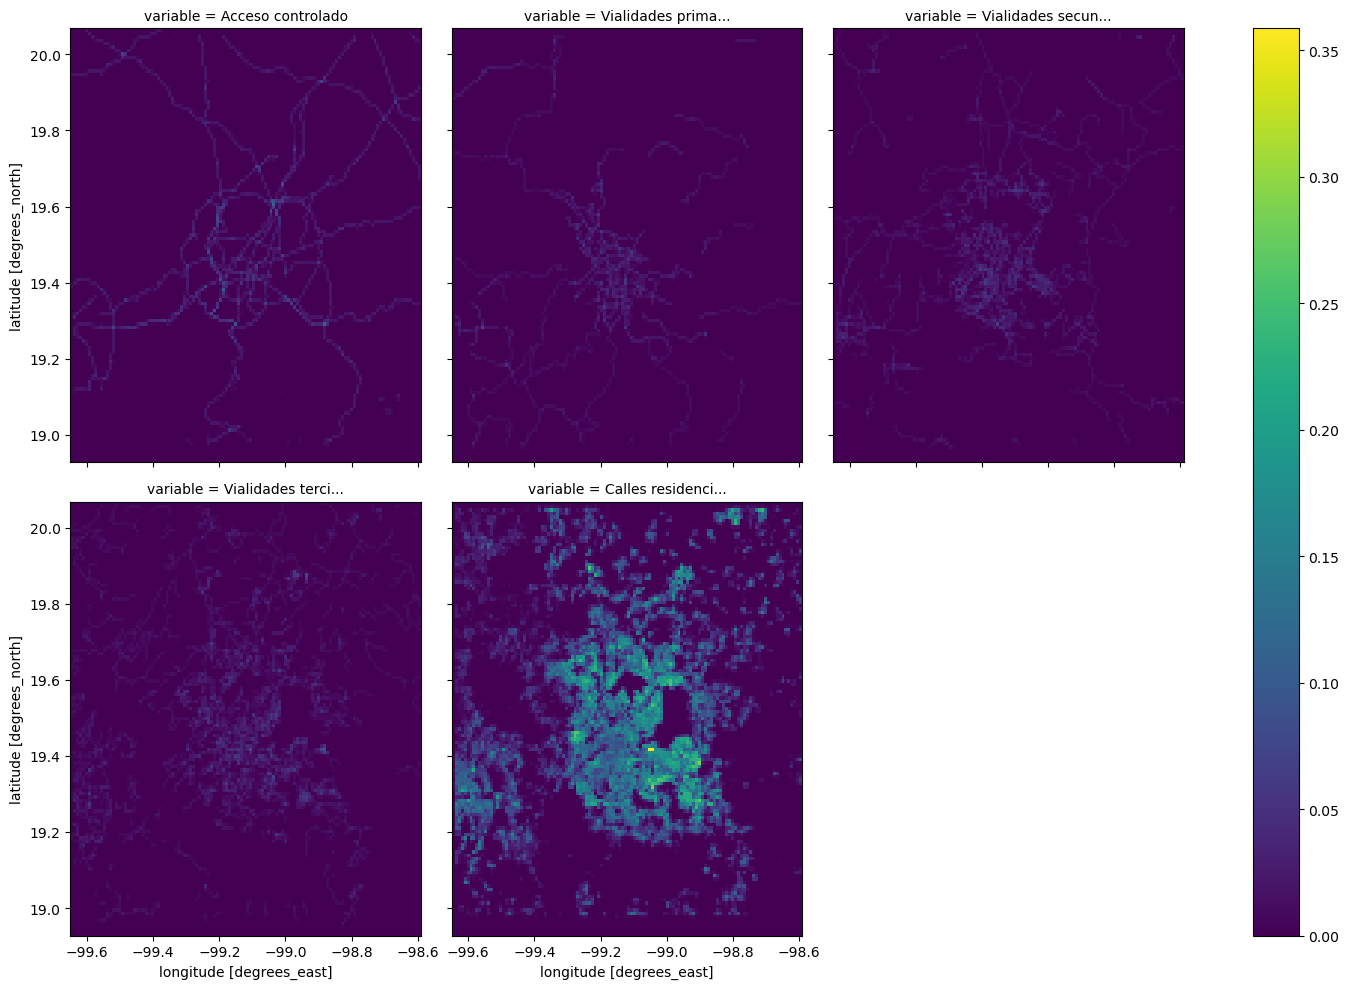

In [ ]:
rasters = malla.to_xarray()
(rasters
 .to_array()
 .plot(col = 'variable', col_wrap=3, figsize=(15, 10)))

## Usos de suelo

Vamos a usar una base con el Denue para toda la ZMVM del 2022.



In [ ]:
pth_denue = os.path.join(DOWNLOADS_PATH, 'denue_2022_zmvm_completo.gpkg')
denue = Denue.desde_archivo(pth_denue)
categorias = {
    'Manufacturas': ['^31.*5$', '^32.*5$', '^33.*5$'],
    'Oficinas': ['^51', '^521', '^523', '^524', '^5312', '^5313', '^541', '^55'],
    'Comercio': ['^46[123456]']
}
pesos = {
        '0 a 5 personas': 2,
        '6 a 10 personas': 8,
        '11 a 30 personas': 20,
        '31 a 50 personas': 40,
        '51 a 100 personas': 75,
        '101 a 250 personas': 175,
        '251 y más personas': 300
        }
usos = (denue
        .pesa_unidades(pesos)
        .agrega_en_usos(categorias))
usos.datos.loc[~usos.datos.Categoria.isnull()].head()

,clee,denue_nombre,denue_razon_social,codigo_act,actividad_nombre,per_ocu,denue_via_tipo,denue_via_nombre,denue_via_ext1_tipo,denue_via_ext1_nombre,...,denue_telefono,correoelec,www,tipoUniEco,denue_latitud,denue_longitud,denue_alta,geometry,pesos,Categoria
1,15096465912000751000000000U3,NOVEDADES YULI,,465912,Comercio al por menor de regalos,0 a 5 personas,AVENIDA,INSURGENTES,AVENIDA,MORELOS,...,,,,Fijo,19.90871265,-99.14674938,2019-11,POINT (-99.14675 19.90871),2,Comercio
6,09005465912009041000000000U9,KAZANA,,465912,Comercio al por menor de regalos,0 a 5 personas,AVENIDA,1-A,CALLE,32-A,...,,,,Fijo,19.52497485,-99.1695219,2019-11,POINT (-99.16952 19.52497),2,Comercio
64,09007463310004711000000000U7,ZAPATERIA JOS JER,,463310,Comercio al por menor de calzado,0 a 5 personas,CALLE,18,CALLE,3,...,,,,Fijo,19.30874225,-99.08205671,2010-07,POINT (-99.08206 19.30874),2,Comercio
221,09015541110023561000000000U6,"ARRANGOIZ ABOGADOS, S.C.",ARRANGOIZ ABOGADOS SC,541110,Bufetes jurídicos,0 a 5 personas,,Durango 263 Col. Roma Norte,,,...,,,,Fijo,19.419205,-99.17030486,2020-11,POINT (-99.17030 19.41921),2,Oficinas
223,09005464111004891000000000U2,FARMACIA SAN JOSE,,464111,Farmacias sin minisúper,0 a 5 personas,CALLE,310,CALLE,317,...,5519006147,,,Fijo,19.49611382,-99.0856781,2010-07,POINT (-99.08568 19.49611),2,Comercio


In [ ]:
usos.datos.loc[usos.datos.Categoria == 'Manufacturas']

NameError: name 'usos' is not defined